In [1]:
import numpy as np
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors

In [2]:
data_file = "data_banknote_authentication.txt"
data_x = np.loadtxt(data_file, delimiter=",", skiprows=0, usecols=range(0,4) ,dtype=np.float64)
data_y = np.loadtxt(data_file, delimiter=",", skiprows=0, usecols=(4,),dtype=np.int64)

In [3]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape) # check the shapes

(1097, 4) (1097,) (275, 4) (275,)


In [5]:
# Helper functions

# Data Normalisation
def minmax_scaler(data):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    return scaled

# Euclidean distance
def e_distance(x,y):
    return distance.euclidean(x,y)

# Manhattan distance
def m_distance(x,y):
    return distance.cityblock(x,y)

# Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
    winner = [0,0]
    shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
    input_data = data[t]
    for row in range(num_rows):
        for col in range(num_cols):
            distance = e_distance(som[row][col], data[t])
            if distance < shortest_distance: 
                shortest_distance = distance
                winner = [row,col]
    return winner

# Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
    coefficient = 1.0 - (np.float64(step)/max_steps)
    learning_rate = coefficient*max_learning_rate
    neighbourhood_range = ceil(coefficient * max_m_dsitance)
    return learning_rate, neighbourhood_range

In [6]:
# hyperparameters
num_rows = 10
num_cols = 10
max_m_dsitance = 4
max_learning_rate = 0.5
max_steps = int(7.5*10e3)

# num_nurons = 5*np.sqrt(train_x.shape[0])
# grid_size = ceil(np.sqrt(num_nurons))
# print(grid_size)

In [7]:
#main function

train_x_norm = minmax_scaler(train_x) # normalisation

# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
    if (step+1) % 5000 == 0:
        print("Iteration: ", step+1) # print out the current iteration for every 5k
    learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

    t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
    for row in range(num_rows):
        for col in range(num_cols):
            if m_distance([row,col],winner) <= neighbourhood_range:
                som[row][col] += learning_rate*(train_x_norm[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")

Iteration:  5000
Iteration:  10000
Iteration:  15000
Iteration:  20000
Iteration:  25000
Iteration:  30000
Iteration:  35000
Iteration:  40000
Iteration:  45000
Iteration:  50000
Iteration:  55000
Iteration:  60000
Iteration:  65000
Iteration:  70000
Iteration:  75000
SOM training completed


In [8]:
# collecting labels

label_data = train_y
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
    for col in range(num_cols):
        map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
    if (t+1) % 1000 == 0:
        print("sample data: ", t+1)
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
    map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

sample data:  1000


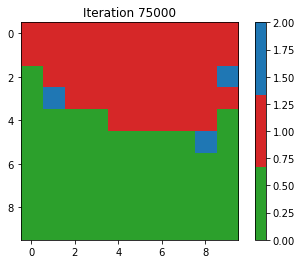

In [10]:
# construct label map
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
    for col in range(num_cols):
        label_list = map[row][col]
        if len(label_list)==0:
            label = 2
        else:
            label = max(label_list, key=label_list.count)
        label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()